In [1]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [27]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import detectron2.data.transforms as T
from detectron2.structures import ImageList
from detectron2.modeling.meta_arch.rcnn import GeneralizedRCNN
from detectron2.checkpoint import DetectionCheckpointer

from src.datasets.apollo_scape import ApolloScape

import matplotlib.pyplot as plt
import torch

In [29]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
model = build_model(cfg)
model.eval()
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

{'__author__': 'Detectron2 Model Zoo'}

In [30]:
apollo = ApolloScape(remote=True, username="jellouli")

Remote server password: ········


In [31]:
img, labels = next(iter(apollo))

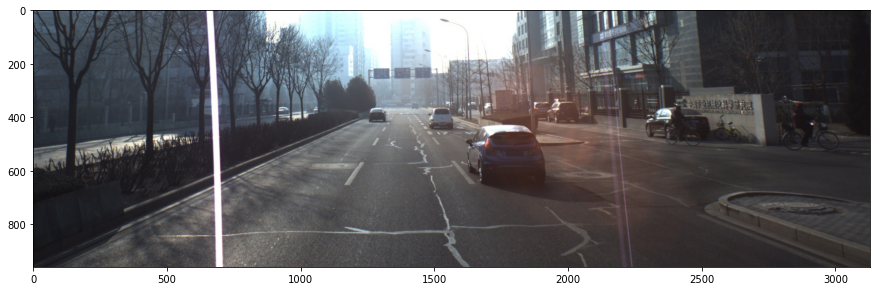

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(img)

In [33]:
aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

In [34]:
height, width = img.shape[:2]
image = aug.get_transform(img).apply_image(img)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
inputs = {"image": image, "height": height, "width": width}
images = model.preprocess_image([inputs])

In [52]:
features = model.backbone(images.tensor)
proposals, _ = model.proposal_generator(images, features, None)
instances, _ = model.roi_heads(images, features, proposals)
# instances =  GeneralizedRCNN._postprocess(instances, [inputs], images.image_sizes)

box_features = [features[f] for f in model.roi_heads.in_features]
box_features = model.roi_heads.box_pooler(box_features, [x.pred_boxes for x in instances])
box_features = model.roi_heads.box_head(box_features)

In [54]:
box_features.shape -> 1024 dimen

torch.Size([16, 1024])

In [42]:
predictor = DefaultPredictor(cfg)

In [45]:
output = predictor(img)
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(instances[0]["instances"].to("cpu"))

In [44]:
output

{'instances': Instances(num_instances=16, image_height=960, image_width=3130, fields=[pred_boxes: Boxes(tensor([[1625.2455,  425.3904, 1915.5828,  651.6484],
         [2385.9941,  351.9506, 2445.4307,  493.5783],
         [1254.5081,  364.5278, 1327.3016,  419.5701],
         [2799.5464,  382.7451, 3014.8945,  526.5902],
         [1479.7369,  364.3494, 1571.7948,  444.7681],
         [2550.2234,  392.0094, 2671.2324,  495.2762],
         [1921.3759,  338.3731, 2047.1255,  422.2082],
         [2839.5569,  338.8968, 2949.8442,  512.1525],
         [1864.2676,  342.5585, 1937.3137,  411.2689],
         [2285.8735,  361.3281, 2533.4355,  475.3937],
         [2288.1008,  364.2905, 2389.3611,  479.0305],
         [2781.2612,  318.0188, 2852.2891,  485.2404],
         [2327.8291,  387.5024, 2514.9561,  503.9775],
         [2545.6777,  395.5667, 2613.8640,  484.5423],
         [1411.9834,  344.7455, 1443.9070,  368.4005],
         [ 915.9478,  360.3783,  958.3900,  388.5343]])), scores: tensor

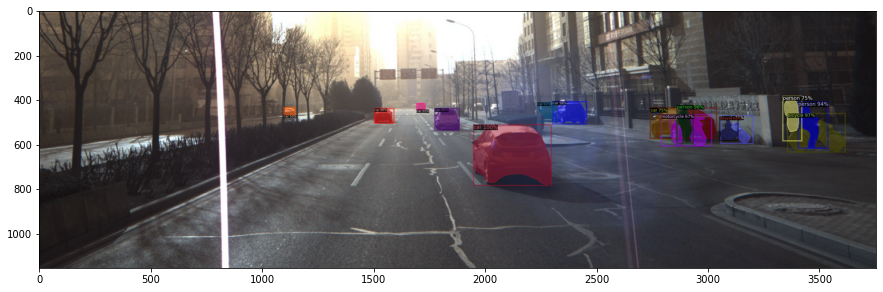

In [46]:
plt.figure(figsize=(15,15))
plt.imshow(out.get_image())

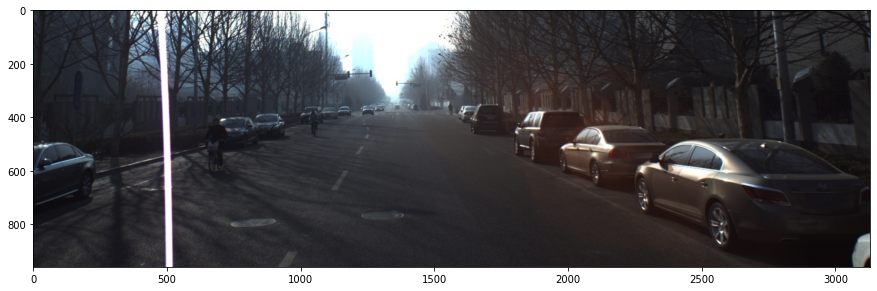

In [31]:
plt.figure(figsize=(15,15))
plt.imshow(img)